**1. IMPORTANT LIBRARIES**

In [1]:
import torch 
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import CIFAR10
import torch.optim as optim

/home/toluwani/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**2. LOADING & USING PYTORCH TRANSFORMS ON CIFAR10**

In [2]:
#augmentations and transforms to be used on the train and test sets
transform = transforms.Compose([
                                transforms.RandomHorizontalFlip(0.5),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

#applying the transforms to the train-test set
train_ds = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_ds = CIFAR10(root='./data', train=False, download=True, transform=transform)

#creating the train and test loaders from their respective sets
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


**3. CODING THE LENET-5 AND ALEXNET ARCHITECTURES**

In [3]:
class LeNet(nn.Sequential):
    def __init__(self, img_channels=3, num_classes=10):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(img_channels, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class AlexNet(nn.Module):
    def __init__(self, img_channels=3, num_classes=10):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=img_channels, out_channels= 96, kernel_size= 3, stride=1, padding=0 )
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3, stride= 1, padding= 1)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.fc1  = nn.Linear(in_features= 9216, out_features= 4096)
        self.fc2  = nn.Linear(in_features= 4096, out_features= 4096)
        self.fc3 = nn.Linear(in_features=4096 , out_features=num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

**4. SETTING UP GPU AND CRITERION**

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #to train on GPU, else CPU
criterion = nn.CrossEntropyLoss()

**5. DEFINING THE TRAIN AND TEST FUNCTION**

In [5]:
def train_test(model, train_loader, test_loader, optimizer, n_epochs):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #to train on GPU, else CPU
    # model in training mode
    model.train()
    train_l = []
    test_acc = []
    for epoch in range(1, n_epochs+1):
        train_accuracy = 0
        train_samples = 0
        train_loss = 0.0
        for data, targets in train_loader:
            data = data.to(device=device)
            targets = targets.to(device=device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            predictions = torch.argmax(output, dim=-1)
            train_samples += predictions.size(0)
            train_accuracy += (predictions == targets).sum()
            train_loss += loss.item()

        # calculate average losses
        train_loss = train_loss / len(train_loader)
        train_l.append(train_loss)

        with torch.no_grad():
            model.eval()
            test_loss = 0
            test_accuracy = 0
            test_samples = 0
            for data,targets in test_loader:
                data = data.to(device=device)
                targets = targets.to(device=device)
                ## Forward Pass
                scores = model(data)
                loss = criterion(scores,targets)
                predictions = torch.argmax(scores, dim=-1)
                test_accuracy += (predictions == targets).sum()
                test_samples += predictions.size(0)
                test_loss += loss.item() 
            t_a = (test_accuracy / test_samples)*100
            test_acc.append(t_a)
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss), f"  Test Accuracy: {t_a:.3f}")
            
    return model, train_l, test_acc

**5(A). TRAINING LENET WITH SGD**

In [6]:
lenet = LeNet().to(device)
sgd_lenet = optim.SGD(lenet.parameters(), lr=1e-3) #SGD
lenet_sgd, loss_sgd, acc_sgd = train_test(lenet, train_dl, test_dl, sgd_lenet, n_epochs=50)

Epoch: 1 	Training Loss: 2.304535   Test Accuracy: 10.000
Epoch: 2 	Training Loss: 2.302970   Test Accuracy: 10.020
Epoch: 3 	Training Loss: 2.301555   Test Accuracy: 11.170
Epoch: 4 	Training Loss: 2.300057   Test Accuracy: 14.420
Epoch: 5 	Training Loss: 2.297940   Test Accuracy: 16.050
Epoch: 6 	Training Loss: 2.294215   Test Accuracy: 17.070
Epoch: 7 	Training Loss: 2.285947   Test Accuracy: 19.070
Epoch: 8 	Training Loss: 2.262126   Test Accuracy: 19.480
Epoch: 9 	Training Loss: 2.181979   Test Accuracy: 21.770
Epoch: 10 	Training Loss: 2.060597   Test Accuracy: 26.220
Epoch: 11 	Training Loss: 1.983677   Test Accuracy: 28.370
Epoch: 12 	Training Loss: 1.934992   Test Accuracy: 30.560
Epoch: 13 	Training Loss: 1.888738   Test Accuracy: 32.110
Epoch: 14 	Training Loss: 1.846068   Test Accuracy: 33.840
Epoch: 15 	Training Loss: 1.803572   Test Accuracy: 35.100
Epoch: 16 	Training Loss: 1.762213   Test Accuracy: 36.380
Epoch: 17 	Training Loss: 1.722939   Test Accuracy: 37.580
Epoch:

**5(B). TRAINING LENET WITH SGD+MOMENTUM**

In [7]:
lenet = LeNet().to(device)
sgdm_lenet = optim.SGD(lenet.parameters(), lr=1e-3, momentum=0.9) #SGD with momentum
lenet_sgdm, loss_sgdm, acc_sgdm = train_test(lenet, train_dl, test_dl, sgdm_lenet, n_epochs=50)

Epoch: 1 	Training Loss: 2.235306   Test Accuracy: 27.830
Epoch: 2 	Training Loss: 1.764317   Test Accuracy: 41.280
Epoch: 3 	Training Loss: 1.556811   Test Accuracy: 46.090
Epoch: 4 	Training Loss: 1.462720   Test Accuracy: 49.220
Epoch: 5 	Training Loss: 1.384669   Test Accuracy: 51.230
Epoch: 6 	Training Loss: 1.326268   Test Accuracy: 52.880
Epoch: 7 	Training Loss: 1.268522   Test Accuracy: 55.210
Epoch: 8 	Training Loss: 1.225106   Test Accuracy: 56.800
Epoch: 9 	Training Loss: 1.189702   Test Accuracy: 57.970
Epoch: 10 	Training Loss: 1.155510   Test Accuracy: 58.770
Epoch: 11 	Training Loss: 1.124351   Test Accuracy: 60.150
Epoch: 12 	Training Loss: 1.093768   Test Accuracy: 60.430
Epoch: 13 	Training Loss: 1.071486   Test Accuracy: 60.830
Epoch: 14 	Training Loss: 1.047049   Test Accuracy: 60.440
Epoch: 15 	Training Loss: 1.028445   Test Accuracy: 62.140
Epoch: 16 	Training Loss: 1.004781   Test Accuracy: 63.620
Epoch: 17 	Training Loss: 0.983164   Test Accuracy: 64.190
Epoch:

**5(C). TRAINING LENET WITH ADAGRAD**

In [8]:
lenet = LeNet().to(device)
ag_lenet = optim.Adagrad(lenet.parameters(), lr=1e-3) #Adagrad
lenet_ag, loss_ag, acc_ag = train_test(lenet, train_dl, test_dl, ag_lenet, n_epochs=50)

Epoch: 1 	Training Loss: 2.000127   Test Accuracy: 31.170
Epoch: 2 	Training Loss: 1.891782   Test Accuracy: 33.340
Epoch: 3 	Training Loss: 1.845419   Test Accuracy: 34.370
Epoch: 4 	Training Loss: 1.810862   Test Accuracy: 35.480
Epoch: 5 	Training Loss: 1.783588   Test Accuracy: 36.640
Epoch: 6 	Training Loss: 1.758252   Test Accuracy: 36.840
Epoch: 7 	Training Loss: 1.735358   Test Accuracy: 38.040
Epoch: 8 	Training Loss: 1.713322   Test Accuracy: 38.710
Epoch: 9 	Training Loss: 1.692633   Test Accuracy: 39.650
Epoch: 10 	Training Loss: 1.673893   Test Accuracy: 40.060
Epoch: 11 	Training Loss: 1.656547   Test Accuracy: 40.820
Epoch: 12 	Training Loss: 1.640804   Test Accuracy: 41.070
Epoch: 13 	Training Loss: 1.628029   Test Accuracy: 41.470
Epoch: 14 	Training Loss: 1.615621   Test Accuracy: 41.730
Epoch: 15 	Training Loss: 1.604297   Test Accuracy: 42.420
Epoch: 16 	Training Loss: 1.594113   Test Accuracy: 42.420
Epoch: 17 	Training Loss: 1.584729   Test Accuracy: 42.690
Epoch:

**5(D). TRAINING LENET WITH RMSPROP**

In [9]:
lenet = LeNet().to(device)
rms_lenet = optim.RMSprop(lenet.parameters(), lr=1e-3) #RMSprop
lenet_rms, loss_rms, acc_rms = train_test(lenet, train_dl, test_dl, rms_lenet, n_epochs=50)

Epoch: 1 	Training Loss: 1.597867   Test Accuracy: 46.500
Epoch: 2 	Training Loss: 1.340487   Test Accuracy: 53.890
Epoch: 3 	Training Loss: 1.222722   Test Accuracy: 51.720
Epoch: 4 	Training Loss: 1.141108   Test Accuracy: 60.780
Epoch: 5 	Training Loss: 1.077743   Test Accuracy: 61.250
Epoch: 6 	Training Loss: 1.026840   Test Accuracy: 63.040
Epoch: 7 	Training Loss: 0.996906   Test Accuracy: 61.680
Epoch: 8 	Training Loss: 0.963120   Test Accuracy: 63.790
Epoch: 9 	Training Loss: 0.938219   Test Accuracy: 64.810
Epoch: 10 	Training Loss: 0.914719   Test Accuracy: 63.500
Epoch: 11 	Training Loss: 0.896194   Test Accuracy: 66.210
Epoch: 12 	Training Loss: 0.875843   Test Accuracy: 63.470
Epoch: 13 	Training Loss: 0.858988   Test Accuracy: 65.510
Epoch: 14 	Training Loss: 0.848570   Test Accuracy: 64.590
Epoch: 15 	Training Loss: 0.838506   Test Accuracy: 66.310
Epoch: 16 	Training Loss: 0.818406   Test Accuracy: 66.420
Epoch: 17 	Training Loss: 0.805991   Test Accuracy: 66.080
Epoch:

**5(E). TRAINING LENET WITH ADAM**

In [10]:
lenet = LeNet().to(device)
adam_lenet = optim.Adam(lenet.parameters(), lr=1e-3) #Adam
lenet_adam, loss_adam, acc_adam = train_test(lenet, train_dl, test_dl, adam_lenet, n_epochs=50)

Epoch: 1 	Training Loss: 1.589832   Test Accuracy: 49.990
Epoch: 2 	Training Loss: 1.283900   Test Accuracy: 57.130
Epoch: 3 	Training Loss: 1.162282   Test Accuracy: 60.130
Epoch: 4 	Training Loss: 1.081875   Test Accuracy: 61.660
Epoch: 5 	Training Loss: 1.031880   Test Accuracy: 62.620
Epoch: 6 	Training Loss: 0.988591   Test Accuracy: 63.250
Epoch: 7 	Training Loss: 0.951032   Test Accuracy: 65.590
Epoch: 8 	Training Loss: 0.928902   Test Accuracy: 64.730
Epoch: 9 	Training Loss: 0.898819   Test Accuracy: 65.820
Epoch: 10 	Training Loss: 0.877524   Test Accuracy: 65.690
Epoch: 11 	Training Loss: 0.860367   Test Accuracy: 66.290
Epoch: 12 	Training Loss: 0.849568   Test Accuracy: 65.940
Epoch: 13 	Training Loss: 0.828032   Test Accuracy: 67.270
Epoch: 14 	Training Loss: 0.814995   Test Accuracy: 66.750
Epoch: 15 	Training Loss: 0.802464   Test Accuracy: 67.280
Epoch: 16 	Training Loss: 0.794991   Test Accuracy: 66.190
Epoch: 17 	Training Loss: 0.782402   Test Accuracy: 67.150
Epoch:

**6(A). TRAINING ALEXNET WITH SGD**

In [14]:
alexnet = AlexNet().to(device)
sgd_alexnet = optim.SGD(alexnet.parameters(), lr=1e-3) #SGD
alexnet_sgd, a_loss_sgd, a_acc_sgd = train_test(alexnet, train_dl, test_dl, sgd_alexnet, n_epochs=50)

Epoch: 1 	Training Loss: 2.302524   Test Accuracy: 10.000
Epoch: 2 	Training Loss: 2.302311   Test Accuracy: 10.000
Epoch: 3 	Training Loss: 2.302094   Test Accuracy: 10.000
Epoch: 4 	Training Loss: 2.301833   Test Accuracy: 10.000
Epoch: 5 	Training Loss: 2.301485   Test Accuracy: 13.750
Epoch: 6 	Training Loss: 2.300991   Test Accuracy: 21.320
Epoch: 7 	Training Loss: 2.300223   Test Accuracy: 22.440
Epoch: 8 	Training Loss: 2.298916   Test Accuracy: 21.490
Epoch: 9 	Training Loss: 2.296408   Test Accuracy: 20.640
Epoch: 10 	Training Loss: 2.290299   Test Accuracy: 19.630
Epoch: 11 	Training Loss: 2.265548   Test Accuracy: 19.270
Epoch: 12 	Training Loss: 2.136194   Test Accuracy: 25.890
Epoch: 13 	Training Loss: 1.980355   Test Accuracy: 30.140
Epoch: 14 	Training Loss: 1.891064   Test Accuracy: 33.780
Epoch: 15 	Training Loss: 1.803016   Test Accuracy: 36.530
Epoch: 16 	Training Loss: 1.713240   Test Accuracy: 36.030
Epoch: 17 	Training Loss: 1.643893   Test Accuracy: 39.120
Epoch:

**6(B). TRAINING ALEXNET WITH SGD+MOMENTUM**

In [15]:
alexnet = AlexNet().to(device)
sgdm_alexnet = optim.SGD(alexnet.parameters(), lr=1e-3, momentum=0.9) #SGD+momentum
alexnet_sgdm, a_loss_sgdm, a_acc_sgdm = train_test(alexnet, train_dl, test_dl, sgdm_alexnet, n_epochs=50)

Epoch: 1 	Training Loss: 2.300221   Test Accuracy: 20.180
Epoch: 2 	Training Loss: 1.909889   Test Accuracy: 40.000
Epoch: 3 	Training Loss: 1.537041   Test Accuracy: 47.350
Epoch: 4 	Training Loss: 1.381929   Test Accuracy: 49.520
Epoch: 5 	Training Loss: 1.265703   Test Accuracy: 57.060
Epoch: 6 	Training Loss: 1.164866   Test Accuracy: 58.980
Epoch: 7 	Training Loss: 1.049995   Test Accuracy: 63.920
Epoch: 8 	Training Loss: 0.945971   Test Accuracy: 66.410
Epoch: 9 	Training Loss: 0.848259   Test Accuracy: 70.580
Epoch: 10 	Training Loss: 0.760642   Test Accuracy: 72.470
Epoch: 11 	Training Loss: 0.683422   Test Accuracy: 74.620
Epoch: 12 	Training Loss: 0.619311   Test Accuracy: 76.590
Epoch: 13 	Training Loss: 0.560506   Test Accuracy: 77.430
Epoch: 14 	Training Loss: 0.505934   Test Accuracy: 78.090
Epoch: 15 	Training Loss: 0.455036   Test Accuracy: 79.530
Epoch: 16 	Training Loss: 0.400832   Test Accuracy: 80.260
Epoch: 17 	Training Loss: 0.361593   Test Accuracy: 79.840
Epoch:

**6(C). TRAINING ALEXNET WITH ADAGRAD**

In [16]:
alexnet = AlexNet().to(device)
ag_alexnet = optim.Adagrad(alexnet.parameters(), lr=1e-3) #adagrad
alexnet_ag, a_loss_ag, a_acc_ag = train_test(alexnet, train_dl, test_dl, ag_alexnet, n_epochs=50)

Epoch: 1 	Training Loss: 1.411487   Test Accuracy: 57.820
Epoch: 2 	Training Loss: 1.005781   Test Accuracy: 66.860
Epoch: 3 	Training Loss: 0.845419   Test Accuracy: 70.830
Epoch: 4 	Training Loss: 0.746006   Test Accuracy: 74.100
Epoch: 5 	Training Loss: 0.673508   Test Accuracy: 72.180
Epoch: 6 	Training Loss: 0.614633   Test Accuracy: 76.340
Epoch: 7 	Training Loss: 0.569588   Test Accuracy: 78.150
Epoch: 8 	Training Loss: 0.528160   Test Accuracy: 78.090
Epoch: 9 	Training Loss: 0.493159   Test Accuracy: 79.390
Epoch: 10 	Training Loss: 0.462638   Test Accuracy: 79.500
Epoch: 11 	Training Loss: 0.436277   Test Accuracy: 80.150
Epoch: 12 	Training Loss: 0.410992   Test Accuracy: 80.290
Epoch: 13 	Training Loss: 0.388640   Test Accuracy: 80.460
Epoch: 14 	Training Loss: 0.364556   Test Accuracy: 81.630
Epoch: 15 	Training Loss: 0.344643   Test Accuracy: 81.220
Epoch: 16 	Training Loss: 0.323256   Test Accuracy: 82.440
Epoch: 17 	Training Loss: 0.305549   Test Accuracy: 81.710
Epoch:

**6(D). TRAINING ALEXNET WITH RMSPROP**

In [17]:
alexnet = AlexNet().to(device)
rms_alexnet = optim.RMSprop(alexnet.parameters(), lr=1e-3) #rmsprop
alexnet_rms, a_loss_rms, a_acc_rms = train_test(alexnet, train_dl, test_dl, rms_alexnet, n_epochs=50)

Epoch: 1 	Training Loss: 781.802014   Test Accuracy: 42.070
Epoch: 2 	Training Loss: 1.277968   Test Accuracy: 61.930
Epoch: 3 	Training Loss: 0.939784   Test Accuracy: 71.400
Epoch: 4 	Training Loss: 0.785330   Test Accuracy: 66.880
Epoch: 5 	Training Loss: 0.701847   Test Accuracy: 72.790
Epoch: 6 	Training Loss: 0.643998   Test Accuracy: 70.570
Epoch: 7 	Training Loss: 0.597814   Test Accuracy: 71.500
Epoch: 8 	Training Loss: 0.568861   Test Accuracy: 76.530
Epoch: 9 	Training Loss: 0.535063   Test Accuracy: 77.620
Epoch: 10 	Training Loss: 0.514097   Test Accuracy: 77.260
Epoch: 11 	Training Loss: 0.509815   Test Accuracy: 78.210
Epoch: 12 	Training Loss: 0.485198   Test Accuracy: 75.270
Epoch: 13 	Training Loss: 0.545038   Test Accuracy: 78.370
Epoch: 14 	Training Loss: 0.462339   Test Accuracy: 80.740
Epoch: 15 	Training Loss: 0.451865   Test Accuracy: 77.530
Epoch: 16 	Training Loss: 0.435248   Test Accuracy: 79.960
Epoch: 17 	Training Loss: 0.430961   Test Accuracy: 79.890
Epoc

**6(E). TRAINING ALEXNET WITH ADAM**

In [18]:
alexnet = AlexNet().to(device)
adam_alexnet = optim.Adam(alexnet.parameters(), lr=1e-3) #Adam
alexnet_adam, a_loss_adam, a_acc_adam = train_test(alexnet, train_dl, test_dl, adam_alexnet, n_epochs=50)

Epoch: 1 	Training Loss: 1.559537   Test Accuracy: 56.710
Epoch: 2 	Training Loss: 1.100123   Test Accuracy: 63.480
Epoch: 3 	Training Loss: 0.926556   Test Accuracy: 68.440
Epoch: 4 	Training Loss: 0.810955   Test Accuracy: 69.820
Epoch: 5 	Training Loss: 0.730435   Test Accuracy: 72.450
Epoch: 6 	Training Loss: 0.659948   Test Accuracy: 72.850
Epoch: 7 	Training Loss: 0.608346   Test Accuracy: 74.960
Epoch: 8 	Training Loss: 0.561820   Test Accuracy: 75.960
Epoch: 9 	Training Loss: 0.516962   Test Accuracy: 76.090
Epoch: 10 	Training Loss: 0.477572   Test Accuracy: 76.590
Epoch: 11 	Training Loss: 0.452566   Test Accuracy: 76.000
Epoch: 12 	Training Loss: 0.415723   Test Accuracy: 76.860
Epoch: 13 	Training Loss: 0.391954   Test Accuracy: 76.880
Epoch: 14 	Training Loss: 0.361552   Test Accuracy: 76.010
Epoch: 15 	Training Loss: 0.343404   Test Accuracy: 75.570
Epoch: 16 	Training Loss: 0.319857   Test Accuracy: 77.460
Epoch: 17 	Training Loss: 0.300923   Test Accuracy: 76.880
Epoch:

In [19]:
alexnet = AlexNet().to(device)
adam_alexnet = optim.Adam(alexnet.parameters(), lr=1e-5) #Adam
alexnet_adam, a_loss_adam, a_acc_adam = train_test(alexnet, train_dl, test_dl, adam_alexnet, n_epochs=50)

Epoch: 1 	Training Loss: 1.702230   Test Accuracy: 44.880
Epoch: 2 	Training Loss: 1.410409   Test Accuracy: 49.030
Epoch: 3 	Training Loss: 1.279573   Test Accuracy: 56.840
Epoch: 4 	Training Loss: 1.174875   Test Accuracy: 59.250
Epoch: 5 	Training Loss: 1.087011   Test Accuracy: 62.310
Epoch: 6 	Training Loss: 1.008962   Test Accuracy: 64.220
Epoch: 7 	Training Loss: 0.939828   Test Accuracy: 66.790
Epoch: 8 	Training Loss: 0.881587   Test Accuracy: 68.470
Epoch: 9 	Training Loss: 0.832144   Test Accuracy: 69.020
Epoch: 10 	Training Loss: 0.779176   Test Accuracy: 71.620
Epoch: 11 	Training Loss: 0.737359   Test Accuracy: 72.670
Epoch: 12 	Training Loss: 0.694408   Test Accuracy: 72.890
Epoch: 13 	Training Loss: 0.652612   Test Accuracy: 74.220
Epoch: 14 	Training Loss: 0.614143   Test Accuracy: 75.480
Epoch: 15 	Training Loss: 0.577868   Test Accuracy: 76.460
Epoch: 16 	Training Loss: 0.536834   Test Accuracy: 76.000
Epoch: 17 	Training Loss: 0.502251   Test Accuracy: 77.260
Epoch:

**PLOTTING THE RESULTS**

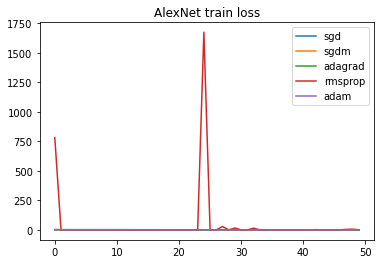

In [20]:
plt.plot(a_loss_sgd, label = "sgd")
plt.plot(a_loss_sgdm, label = "sgdm")
plt.plot(a_loss_ag, label = "adagrad")
plt.plot(a_loss_rms, label = "rmsprop")
plt.plot(a_loss_adam, label = "adam")
plt.legend(loc="upper right")
plt.title("AlexNet train loss")
plt.show()

In [ ]:
plt.plot(a_acc_sgd, label = "sgd")
plt.plot(a_acc_sgdm, label = "sgdm")
plt.plot(a_acc_ag, label = "adagrad")
plt.plot(a_acc_rms, label = "rmsprop")
plt.plot(a_acc_adam, label = "adam")
plt.legend(loc="upper right")
plt.title("AlexNet test accuracy")
plt.show()

**7. FURTHER EXPERIMENTS**